In [ ]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from math import exp, sqrt, pi
import string
from sklearn.model_selection import train_test_split
import random


### Uploading our text files
We collected 31 text files, 15 in French and 16 in English. We wrote the Python script "combine.py" to write all the the French (English) texts in a single txt file called total_fr (total_en), each text being separated by the string '||'. 

In [ ]:
# Choose File to be uploaded (falldataproject.csv)
from google.colab import files
en = files.upload()

Saving total_fr.txt to total_fr (3).txt
Saving total_en.txt to total_en (3).txt


In [ ]:
with open('total_en.txt',encoding ="utf8") as f:
        text_en = f.read()
        
with open('total_fr.txt',encoding ="utf8") as f:
        text_fr = f.read()
        
articles_fr = text_fr.split('||')[1:]
articles_en = text_en.split('||')[1:]

## Language Dataframe


On notera - 1 le français et 1 l'anglais 

In [ ]:
def create_D(text_en, text_fr):
  #creates D mentioned in 1.1
  text_en=text_en.replace("\n", ' ')
  text_fr=text_fr.replace("\n", ' ')

  textes_en = text_en.split('||')

  textes_en = list(filter(('').__ne__, textes_en))
  textes_fr = text_fr.split('||')

  textes_fr= list(filter(('').__ne__, textes_fr))

  X = textes_fr +textes_en
  y = [-1 for i in range(len(textes_fr))] + [1 for i in range(len(textes_en))]

  data = {'fichier':X, 'langue':y}
  D = pd.DataFrame(data)  
  return D

data_brut= create_D(text_en, text_fr)
data_brut

,fichier,langue
0,L'avènement des Angiospermes (du grec sperma «...,-1
1,Les caspases sont indispensables à l'apoptose ...,-1
2,Les cellules végétales sont des systèmes vivan...,-1
3,"Dans l'Église orthodoxe, le jour de Pâques, le...",-1
4,Des fleurs présentent des mouvements dans des ...,-1
5,"À la fin de la période védique, vers le ve siè...",-1
6,L’inflammation bien contrôlée est une réponse ...,-1
7,Le pelage des macaques va du beige au noir en ...,-1
8,Les mitochondries sont souvent décrites comme ...,-1
9,Moutarde allemande (Süßer Senf). Il y a trois ...,-1


In [ ]:
#un texte en français
data_brut.fichier[0]

"L'avènement des Angiospermes (du grec sperma « graines » et angeion « pot » ou « récipient ») est un saut évolutif en ce sens qu'elles enferment leurs ovules (puis leurs graines) dans un ovaire, ce qui les protège, à l'inverse de leur groupe frère, les Gymnospermes (du grec sperma « graines » et gymno « nu ») qui ont des cônes femelles sur lesquels se développent les ovules nus à l'aisselle d'écailles ovulifères. C'est sans doute Théophraste qui, le premier, distingue les Angiospermes des Gymnospermes dans son atlas de botanique Historia Plantarum. À la fin du xviie siècle, John Ray utilise cette différence dans sa classification, qui est la première tentative de classification naturelle de l'époque moderne, basée chez les Angiospermes sur le nombre des cotylédons de la graine. C'est de lui que date la distinction entre Monocotylédones et Dicotylédones4.  L'origine des Angiospermes était pour Darwin un « abominable mystère »5. Bien que les plantes aient colonisé la terre ferme il y a 

In [ ]:
#un texte en anglais
data_brut.fichier[20]

'Harold I Harefoot was born in Denmark around the year 1012. earned the name "Harefoot" for his speed and skill at hunting. He was the illegitimate son of King Canute by his concubine Aelgifu. Harold\'s younger half-brother Harthacanute, the son of Canute and his queen, Emma of Normandy, was the legitimate heir to the thrones of both Denmark and England at Canute\'s death in 1035. However, because Denmark was threatened with invasion from Norway, Harthacanute was unable to travel to England and instead sent as regents Emma and Harold Harefoot. Harold took effective power in England and in 1036 secured recognition by Harthacanute as regent during the latter\'s absence in Denmark. Harold and Emma argued over who should govern the kingdom. The powerful Earl Godwin sided with Harold, and in 1037, after Emma had fled, Harold seized the treasury at Winchester and thus the throne, and was crowned at Oxford.  In general little is known about his reign and he appears to have been a colourless a

In [ ]:
#Jusqu'a l'exercice 3 , on utilisera le dataframe D qui est une copy de data. On aura besoin de data (texte non propre) à l'exo 4
D= data_brut.copy()

Dans une optique de normalisaton des textes français / anglais, nous ne considèrerons que les lettres de l'alphabet classique en minuscule, l'espace et l'apostrophe. Les à, â etc seront remplacé par a, ç par c etc. Si on rencontre une lettre autre, on l'ignore. 

In [ ]:
dico_lettre  = {"à":'a', "â":'a',     
     "é":'e', "è": 'e',
     "ï":'e',
     "ù":'u',
     "ô":'o',
     "ç":'c',
     "'": "'",
     ' ': ' '#on laisse l'espace dans le jeu de données
}
for lettre in  list(string.ascii_lowercase):
  dico_lettre[lettre] = lettre

def normalisation(fichier):
  lower = fichier.lower()#on mets les lettres en minuscule 
  texte_normal = ''
  for lettre in lower:
    if lettre in dico_lettre.keys():
      texte_normal += dico_lettre[lettre]
  return texte_normal

D['fichier'] = D['fichier'].map(normalisation)
D.fichier[0]

"l'avenement des angiospermes du grec sperma  graines  et angeion  pot  ou  recipient  est un saut evolutif en ce sens qu'elles enferment leurs ovules puis leurs graines dans un ovaire ce qui les protege a l'inverse de leur groupe frere les gymnospermes du grec sperma  graines  et gymno  nu  qui ont des cones femelles sur lesquels se developpent les ovules nus a l'aisselle d'ecailles ovuliferes c'est sans doute theophraste qui le premier distingue les angiospermes des gymnospermes dans son atlas de botanique historia plantarum a la fin du xviie siecle john ray utilise cette difference dans sa classification qui est la premiere tentative de classification naturelle de l'epoque moderne basee chez les angiospermes sur le nombre des cotyledons de la graine c'est de lui que date la distinction entre monocotyledones et dicotyledones  l'origine des angiospermes etait pour darwin un  abominable mystere  bien que les plantes aient colonise la terre ferme il y a plus de  millions d'annees l'age 

In [ ]:
D.fichier[20]

"harold i harefoot was born in denmark around the year  earned the name harefoot for his speed and skill at hunting he was the illegitimate son of king canute by his concubine aelgifu harold's younger halfbrother harthacanute the son of canute and his queen emma of normandy was the legitimate heir to the thrones of both denmark and england at canute's death in  however because denmark was threatened with invasion from norway harthacanute was unable to travel to england and instead sent as regents emma and harold harefoot harold took effective power in england and in  secured recognition by harthacanute as regent during the latter's absence in denmark harold and emma argued over who should govern the kingdom the powerful earl godwin sided with harold and in  after emma had fled harold seized the treasury at winchester and thus the throne and was crowned at oxford  in general little is known about his reign and he appears to have been a colourless and weak character his period of rule is

### Log Frequencies Matrix

We create the matrix X = log(1 + fij) pour chaque texte avec fij la frequence d'apparition de chaque lettre

In [ ]:
#on crée un dictionnaire de comptage initialisé à 0
l_tot = list(set(dico_lettre.values()))
l_tot.sort() # on trie les lettres 

symboles = l_tot
n = len(D)
data = {}
for j in symboles:
  data[j] = [0 for i in range(n)]
data['langue'] = list(D['langue'])

In [ ]:
#creaton de la matrice de comptage des frequences log(1 + fij)

def create_X(D, data):
  #function to create the X matrix defined in 1.2
  #comptage des appartition
  X = pd.DataFrame(data)
  l_langue = list(X['langue'])
  count = 0
  for i in D['fichier']:
    for carac in i:
      if carac in symboles:
        X[carac][count]+=1
    count+=1
  #calcul des frequence d'apparition  par fichier 
  X = X.div(X.sum(axis=1), axis=0)

  #Calcul des log proba
  X_log = np.log(1+X)
  X_log['langue'] = l_langue
  return X_log

X= create_X(D, data)
X.head()

,,',a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,langue
0,0.155133,0.013148,0.061589,0.005280,0.022508,0.032807,0.134986,0.011579,0.013148,0.005806,0.055598,0.001058,0.0,0.058099,0.021990,0.059596,0.042493,0.028700,0.008959,0.044014,0.073465,0.051584,0.043001,0.008959,0.000529,0.001058,0.005806,0.001587,-1
1,0.141621,0.007893,0.058478,0.003165,0.033505,0.035037,0.147108,0.007893,0.010248,0.005531,0.054734,0.000792,0.0,0.044176,0.027356,0.055484,0.044934,0.032739,0.005531,0.038092,0.076990,0.062208,0.047204,0.008679,0.000000,0.005531,0.005531,0.002374,-1
2,0.142765,0.005644,0.057438,0.003140,0.040671,0.029131,0.152532,0.006270,0.008143,0.008766,0.041878,0.000629,0.0,0.078009,0.018692,0.053869,0.039463,0.026685,0.007519,0.039463,0.078590,0.057438,0.040067,0.012500,0.000000,0.003766,0.007519,0.000629,-1
3,0.160740,0.014647,0.067427,0.008016,0.025821,0.036871,0.128236,0.006685,0.007351,0.005351,0.061768,0.002679,0.0,0.055443,0.015968,0.052902,0.042029,0.020578,0.006685,0.057345,0.066800,0.057978,0.049078,0.006685,0.000000,0.004016,0.000670,0.000000,-1
4,0.147166,0.003860,0.053456,0.002317,0.025956,0.029716,0.126936,0.013062,0.003860,0.006936,0.051255,0.002317,0.0,0.049048,0.032715,0.059304,0.052723,0.029716,0.003089,0.060033,0.075929,0.068735,0.051989,0.007704,0.000000,0.003860,0.000773,0.000773,-1


### Log Frecuency Histogram

We are going to plot histograms of the symboles log-frequencies for both classes. Histogram des log-frequences des symboles. Nous prendront la moyenne des fréquences d'appartition pour chaque symbole sur l'ensemble des textes 

In [ ]:
moy= X.groupby('langue').mean().T
moy =  pd.concat([moy[-1], moy[1]]).to_frame().rename(columns={0:'log frequence moyenne'})
n_sur_2 = int(moy.shape[0]/2)
langue =['Français' for i in range(n_sur_2)]
langue.extend(['Anglais' for i in range(n_sur_2)] )
moy['langue'] = langue
moy.head()
moy['lettre'] = moy.index.to_list()
moy = moy.reset_index(drop=True)

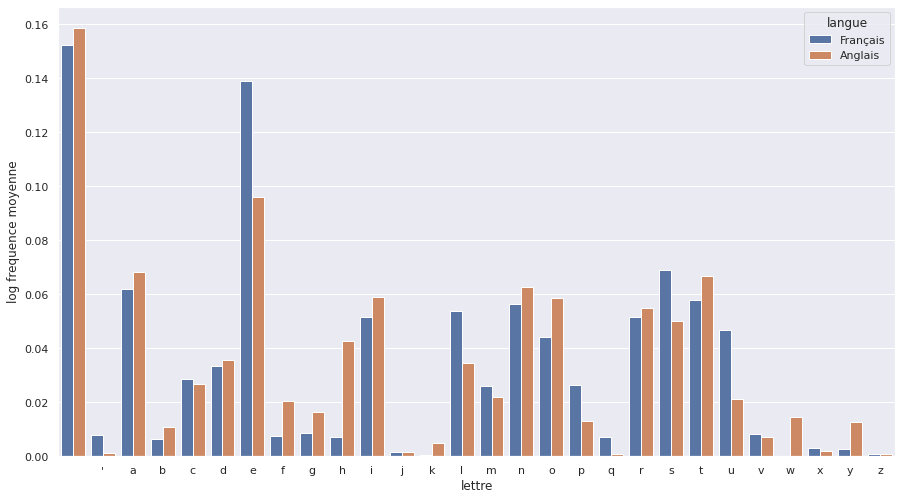

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(data = moy,x = 'lettre', y="log frequence moyenne", hue="langue",)

Commentaire: On voit que certains lettres n'ont pas la même fréquence en fonction des langues. Certaines sont plus fréquents dans les textes français comme q par exemple alors que d'autres comme le sont plus présents dans les textes anglais. 

## Naive Bayes Algorithm

### Computing the Means and the Standard Deviations

We compute the means and the standard deviations for the two language classes:

In [ ]:
mean_fr = np.mean(X.loc[X['langue']==-1])[:-1]
mean_en = np.mean(X.loc[X['langue']==1])[:-1]

In [ ]:
std_fr = np.std(X.loc[X['langue']==-1])[:-1]
std_en = np.std(X.loc[X['langue']==1])[:-1]

In [ ]:
print("mean_fr = \n", mean_fr, "\n mean_en = \n", mean_en, "\n std_fr = \n", std_fr, "\n std_en = \n", std_en)

mean_fr = 
      0.152425
'    0.007997
a    0.061898
b    0.006321
c    0.028624
d    0.033380
e    0.139034
f    0.007476
g    0.008684
h    0.007014
i    0.051648
j    0.001702
k    0.000499
l    0.053969
m    0.026210
n    0.056469
o    0.044311
p    0.026364
q    0.007048
r    0.051570
s    0.069090
t    0.058051
u    0.046752
v    0.008244
w    0.000187
x    0.003077
y    0.002888
z    0.000900
dtype: float64 
 mean_en = 
      0.158555
'    0.001390
a    0.068117
b    0.011022
c    0.026742
d    0.035807
e    0.096075
f    0.020404
g    0.016225
h    0.042709
i    0.058874
j    0.001425
k    0.005045
l    0.034442
m    0.021856
n    0.062548
o    0.058477
p    0.013099
q    0.000870
r    0.054929
s    0.050243
t    0.066841
u    0.021396
v    0.007324
w    0.014624
x    0.001808
y    0.012617
z    0.000696
dtype: float64 
 std_fr = 
      0.009761
'    0.004081
a    0.006375
b    0.002561
c    0.007002
d    0.006793
e    0.008710
f    0.003256
g    0.002355
h    0.002620
i    0.

### Naive Bayes Class

In this part of the project we program a Naive Bayes classifier. The trainning data is represented by log frequencies of text symboles and the labels are associated values of -1 and 1 repressenting French or English. 
The program computes the means and the standard deviations for each class and then, using the assumption that data is extracted from two gaussian distributions, calculates the probabilities that a new observation is part of each gaussian.

In [ ]:
class Gaussian_Naive_Bayes_modif:

    def __init__(self):
      # means and stds are dictionaries; Example: self.means[-1] is the mean for the French class
        self.means = {}
        self.stds = {}

    def gaussian_prob(self, obs, mu, sigma):
      ## function to calculate the gaussian probability distribution
        return (1 / sqrt(2 * pi * sigma ** 2)) * exp(-((obs - mu) ** 2) / (2 * sigma ** 2))

    def train(self, data):
      ## function which calculates the means and the stds  
        self.means[-1] = np.mean(data.loc[data['langue']==-1])[:-1]
        self.means[1] = np.mean(data.loc[data['langue']==1])[:-1]

        self.stds[-1] = np.std(data.loc[data['langue']==-1])[:-1]
        self.stds[1] = np.std(data.loc[data['langue']==1])[:-1]
        

    def predict_probs(self, obs):
      # given an observation, this method computes the probababilites of it being part of the French or English class
        probs = {}
        for label in [-1,1]:

            product = 0.5 #la proba que le texte soit fr/en = 0.5 de base 
            for feature in range(obs.shape[0]): #on ajoute les proba conditionnel pour chaque lettre
                product *= self.gaussian_prob(obs[feature], self.means[label][feature], self.stds[label][feature])

            probs[label] = product
        return probs

    def predict(self, observations):
      # this method assigns the most probable class to a given observation
      labels_predits = []
      n = observations.shape[0]
      for i in range(n):
        observation = observations.iloc[i]
        probs = self.predict_probs(observation)
        if probs[-1] > probs[1]:
          labels_predits.append(-1)
        else:
          labels_predits.append(1)

      return labels_predits

In [ ]:
g = Gaussian_Naive_Bayes_modif()
g.train(X)

#prediction sur les deux 1ers textes
print('predit :', g.predict(X.iloc[-2:, :-1]))
print('réel :', X.langue[-2:].values)

predit : [1, 1]
réel : [1 1]


### Cross Validation

In [ ]:
cv = 10 #on fera 10 fois l'opération
accuracy = []
for i in range(cv):

  #shuffle: on permute de maniere aléatoire les textes et on choisi 20 1ers en train et le reste en test
  train = X.iloc[np.random.permutation(X.shape[0])][:20]
  
  test= X[~X.index.isin(train.index)].iloc[:, :-1] # on prend toutes les colonnes sauf langue en test
  y_test = X[~X.index.isin(train.index)]['langue'] #les vraies langues 

  g = Gaussian_Naive_Bayes_modif() # define the model
  g.train(train) # train the model
  
  pred= g.predict(test)   # prediction
  accuracy.append( sum(pred == y_test)/len(pred))

print("l'accuracy pour les différentes convolution est: ", accuracy)

l'accuracy pour les différentes convolution est:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Le naive bayes classifie parfaitement les textes français/anglais. 

# Markov Classifier

On mets tous les textes d'une nettoyés dans un seul string avec des espaces pour separer les textes, pour calculer la matrice de transition.

In [ ]:
toutes_texte_clean_fr = ''
for texte in D[D.langue == -1].fichier:
  toutes_texte_clean_fr+= texte + ' '

toutes_texte_clean_en = ''
for texte in D[D.langue == 1].fichier:
  toutes_texte_clean_en+= texte + ' '
  

We write the pi(x) function to estimate the initial probability of each Markov Chain and the A(x) function to estimate the transition matrices.

In [ ]:
def pi(x): 
  'function that computes the probability of the first symbol'
  pi = {}
  for i in symboles:
    pi[i] = 0
  S = 0
  for carac in x:
    if carac in symboles:
        pi[carac] += 1
        S+= 1
  for i in symboles:
    pi[i] = pi[i]/S
  return pd.DataFrame(pi, [0])

In [ ]:
pi_en= pi(toutes_texte_clean_en)  ### the initial probabilities for the first text in our database
pi_fr = pi(toutes_texte_clean_fr)
pi_fr

,,',a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0.16509,0.008346,0.063866,0.006558,0.028336,0.034298,0.149233,0.007352,0.008823,0.007034,0.053811,0.001629,0.000517,0.055798,0.026548,0.057905,0.04483,0.026389,0.007273,0.053295,0.071298,0.059296,0.047214,0.008425,0.000199,0.002861,0.002901,0.000874


In [ ]:
pi_en

,,',a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0.170323,0.001412,0.069594,0.011396,0.028343,0.036456,0.101649,0.020198,0.016651,0.043156,0.061843,0.001182,0.004795,0.034584,0.022497,0.064503,0.060595,0.01386,0.001051,0.057081,0.050709,0.068543,0.021118,0.007849,0.014484,0.001905,0.0134,0.000821


In [ ]:
def A(x): 
  # function that computes the transition matrix from symbole to symbole for the text x
  S = {}
  A = defaultdict(dict)
  for i in symboles:
    S[i] = 0
    for j in symboles:
      A[i][j] = 0

  for i in range(len(x)-1):
    if x[i] in symboles and x[i+1] in symboles:
      A[x[i]][x[i+1]]+=1
  
  
  for i in symboles:
    for v in A[i].values():
      S[i]+=v

  for i in symboles:
    for j in symboles:
      if S[i] >0:
        A[i][j] /=S[i]
      
      
 # for i in symboles:
  #  pi[i] = pi[i]/S
  return pd.DataFrame(A)

We can now compute the transition matrixes for  the two languages

In [ ]:
tran_en = A(toutes_texte_clean_en)
tran_fr = A(toutes_texte_clean_fr)
tran_en.sum(axis = 0)  # checking that the sum of a columns is equal to 1

     1.0
'    1.0
a    1.0
b    1.0
c    1.0
d    1.0
e    1.0
f    1.0
g    1.0
h    1.0
i    1.0
j    1.0
k    1.0
l    1.0
m    1.0
n    1.0
o    1.0
p    1.0
q    1.0
r    1.0
s    1.0
t    1.0
u    1.0
v    1.0
w    1.0
x    1.0
y    1.0
z    1.0
dtype: float64

In [ ]:
tran_fr

,,',a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
,0.038526,0.000000,0.179216,0.000000,0.040673,0.048667,0.344607,0.059459,0.031532,0.005650,0.059084,0.024390,0.153846,0.042023,0.019461,0.165408,0.003546,0.013554,0.0,0.158837,0.544036,0.349196,0.117003,0.014151,0.2,0.486111,0.164384,0.590909
',0.000000,0.000000,0.000000,0.000000,0.012623,0.056779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.081909,0.000000,0.003432,0.000000,0.000000,0.0,0.000000,0.008919,0.000000,0.013468,0.000000,0.0,0.000000,0.000000,0.000000
a,0.069347,0.319048,0.000000,0.169697,0.092567,0.096176,0.006658,0.118919,0.112613,0.209040,0.021418,0.268293,0.230769,0.188034,0.166168,0.032944,0.001773,0.194277,0.0,0.084265,0.034002,0.093834,0.010943,0.155660,0.2,0.013889,0.082192,0.045455
b,0.012039,0.000000,0.022402,0.006061,0.000000,0.000000,0.001864,0.000000,0.000000,0.000000,0.008863,0.000000,0.000000,0.000712,0.038922,0.000000,0.004433,0.000000,0.0,0.010440,0.001115,0.000000,0.009259,0.000000,0.0,0.000000,0.000000,0.000000
c,0.082109,0.000000,0.032981,0.000000,0.018233,0.000000,0.023968,0.000000,0.000000,0.000000,0.030281,0.048780,0.000000,0.000712,0.000000,0.041181,0.039894,0.001506,0.0,0.009694,0.007246,0.002011,0.024411,0.000000,0.0,0.041667,0.068493,0.000000
d,0.143752,0.000000,0.018046,0.006061,0.000000,0.005794,0.006125,0.000000,0.000000,0.000000,0.025849,0.000000,0.000000,0.000712,0.000000,0.052848,0.015071,0.000000,0.0,0.033557,0.000000,0.001340,0.024411,0.000000,0.0,0.000000,0.027397,0.000000
e,0.087407,0.323810,0.004356,0.090909,0.252454,0.535342,0.017843,0.167568,0.238739,0.310734,0.143279,0.048780,0.000000,0.400997,0.327844,0.133837,0.001773,0.200301,0.0,0.291573,0.104236,0.187668,0.138889,0.490566,0.0,0.125000,0.082192,0.181818
f,0.020708,0.000000,0.001867,0.000000,0.000000,0.000000,0.003196,0.102703,0.000000,0.000000,0.026588,0.000000,0.000000,0.000000,0.000000,0.011668,0.002660,0.000000,0.0,0.002237,0.000557,0.000000,0.004209,0.000000,0.0,0.000000,0.000000,0.000000
g,0.013484,0.000000,0.014935,0.000000,0.000000,0.000000,0.008788,0.000000,0.000000,0.000000,0.023634,0.000000,0.153846,0.000712,0.000000,0.027454,0.010638,0.000000,0.0,0.012677,0.000000,0.000000,0.004209,0.000000,0.0,0.000000,0.000000,0.000000
h,0.006261,0.042857,0.001867,0.006061,0.122020,0.009270,0.000000,0.000000,0.000000,0.000000,0.000739,0.000000,0.000000,0.000712,0.000000,0.000000,0.001773,0.025602,0.0,0.001491,0.001672,0.010724,0.000000,0.000000,0.0,0.000000,0.000000,0.045455


In [ ]:
tran_en

,,',a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
,0.028930,0.093023,0.063709,0.000000,0.040556,0.553153,0.309532,0.391870,0.305720,0.154490,0.015932,0.000000,0.253425,0.145299,0.135766,0.262729,0.091599,0.049763,0.00000,0.151899,0.440415,0.169142,0.010886,0.016736,0.054422,0.120690,0.816176,0.00
',0.000000,0.000000,0.000944,0.000000,0.000000,0.007207,0.000969,0.000000,0.005917,0.000000,0.001062,0.000000,0.006849,0.003799,0.000000,0.003564,0.000000,0.000000,0.00000,0.001151,0.003238,0.000479,0.000000,0.000000,0.000000,0.000000,0.012255,0.00
a,0.118033,0.000000,0.000000,0.112392,0.120510,0.032432,0.042973,0.042276,0.071006,0.112633,0.039830,0.416667,0.027397,0.120608,0.204380,0.057536,0.014092,0.118483,0.03125,0.065593,0.014249,0.053666,0.043546,0.104603,0.247166,0.051724,0.019608,0.52
b,0.042237,0.000000,0.020293,0.000000,0.000000,0.000000,0.001292,0.001626,0.000000,0.000000,0.010090,0.000000,0.006849,0.000000,0.032117,0.001527,0.003794,0.000000,0.00000,0.001726,0.000648,0.000000,0.027994,0.000000,0.009070,0.000000,0.004902,0.00
c,0.046287,0.000000,0.035394,0.023055,0.024334,0.000901,0.035541,0.000000,0.000000,0.001522,0.077005,0.000000,0.000000,0.001899,0.000000,0.040733,0.016802,0.000000,0.00000,0.043153,0.009067,0.002875,0.076205,0.000000,0.000000,0.068966,0.000000,0.00
d,0.034137,0.000000,0.032563,0.017291,0.000000,0.005405,0.097577,0.004878,0.021696,0.000000,0.022305,0.000000,0.000000,0.043685,0.000000,0.164969,0.022222,0.000000,0.00000,0.033372,0.005181,0.000000,0.026439,0.000000,0.000000,0.000000,0.000000,0.00
e,0.039537,0.000000,0.001888,0.265130,0.149479,0.152252,0.022294,0.065041,0.132150,0.468798,0.057886,0.194444,0.164384,0.132953,0.226277,0.065173,0.003794,0.177725,0.00000,0.227848,0.106865,0.114998,0.040435,0.581590,0.158730,0.137931,0.022059,0.24
f,0.043202,0.000000,0.009910,0.000000,0.000000,0.000901,0.010339,0.032520,0.000000,0.000000,0.020181,0.000000,0.006849,0.009497,0.000000,0.006619,0.129539,0.000000,0.00000,0.003452,0.002591,0.000000,0.004666,0.000000,0.000000,0.051724,0.000000,0.00
g,0.014272,0.000000,0.018877,0.000000,0.000000,0.002703,0.014540,0.000000,0.005917,0.000000,0.023898,0.000000,0.000000,0.002849,0.000000,0.118126,0.004336,0.000000,0.00000,0.013234,0.000648,0.000479,0.045101,0.000000,0.000000,0.000000,0.000000,0.00
h,0.054966,0.000000,0.000472,0.000000,0.186559,0.000901,0.000969,0.000000,0.074951,0.000000,0.001062,0.000000,0.000000,0.000000,0.000000,0.000509,0.001626,0.016588,0.00000,0.000575,0.040155,0.325827,0.000000,0.000000,0.154195,0.000000,0.000000,0.04


## Markov Classifier Class

The class Markov_Model has the following methods:

---


pi, A: compute the initial probabilities and transition matrix of a text a text 

train: computes initial probabilities and transition matrices for the two classes: English and French

Markov_Classifier: calculates the scores for a text being French or English

predict: assigns labels for a dataset represented by different texts



In [ ]:

class Markov_Model_modif:
  def __init__(self):
    self.pi_en = None
    self.pi_fr = None
    self.tran_en = None
    self.tran_fr = None

  def fit(self, data):
    #selection des textes français
    text_fr = ''
    for texte in data[data.langue == -1].fichier:
      text_fr+= texte + ' '

    #selection des textes anglais
    text_en = ''
    for texte in data[data.langue == 1].fichier:
      text_en+= texte + ' '

    #calcul des pi et matrice de transition
    #pour eviter de tomber sur 0 à force de multiplier les frequences, on prendra le log (f) + 10e-8, le 10e-8 pour eviter l'infini
    self.pi_en = pi(text_en)   
    self.pi_fr = pi(text_fr)
    self.tran_en = A(text_en) 
    self.tran_fr = A(text_fr)



  def Markov_classifier(self, text):
    #### function that predicts if a text is in French or English
    
    #On calcule les log vraisemeblance en fct des deux modèle, la plus grande gagne
    #proba de la premiere lettre en fonction des pi
    score_fr = np.log(self.pi_fr[text[0]][0] + 1) #j'ajoute +1 pour le cas 0
    score_en = np.log(self.pi_en[text[0]][0] + 1 ) #j'ajoute +1 pour le cas 0

    #proba des transition
    for i in range(len(text)-1):
      score_fr += np.log(self.tran_fr[text[i]][text[i+1]] + 1) #j'ajoute +1 pour le cas 0
      score_en += np.log(self.tran_en[text[i]][text[i+1]] + 1) #j'ajoute +1 pour le cas 0

    if score_fr > score_en:
      langue_predit= -1
    else:
      langue_predit =  1

    return {'langue_predit':langue_predit, 'score_fr': score_fr , 'score_en': score_en}

  def predict(self, data):
    y_pred = []
    for text in data:
      y_pred.append(self.Markov_classifier(text)['langue_predit'])
    return y_pred

## Cross Validiation 

We now test our Markov classifier class.

Crossvalidation: On prendra cv echantillons différents pour tester le modele avec à chaque fois 20 textes en train et le reste en test après avoir shuffle le jeu de données

In [ ]:
cv = 10
accuracy = []
for i in range(cv):

  #shuffle: on permute de maniere aléatoire les textes et on choisi 20 1ers en train et le reste en test
  train = D.iloc[np.random.permutation(len(D))][:20]
  
  test= D[~D.index.isin(train.index)][['fichier', 'langue']]

  MM = Markov_Model_modif()  # define the model

  MM.fit(train)  # train the model
  
  pred= MM.predict(test.fichier)   # check wheter the predictions are correct
  accuracy.append( sum(pred == test.langue)/len(pred))

In [ ]:
print('accuracy des différentes convolutions')
accuracy

accuracy des différentes convolutions


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

On voit que le modele de markov trouve parfaitement la langue des textes

### Viterbi Algorithm

Pour choisir la phrase, on se mettra sur un texte aléatoirement, on choisira un mot de départ aléatoire dans le texte et on prendra les 20 mots suivants avant de recommencer l'opération jusqu'à atteindre les 1000 caractères au plus.

In [ ]:
D['split phrase'] = D.apply(lambda x: x.fichier.split(' '), axis = 1)

In [ ]:
def generate_random_sentences(D):
    taille_texte = 0
    texte = []
    langue = []
    while taille_texte<1001:
      
      #on choisit un texte au hasard
      ligne = random.randint(0,data_brut.shape[0]-1) 

      #on choisit une phrase au hasard dans ce texte
      num_mot_depart = random.randint(0,len(D.iloc[ligne]['split phrase'] )-20) 
      mots_choisis =   D.iloc[ligne]['split phrase'][num_mot_depart: num_mot_depart+50]

      #on reconstitue la phrase en texte
      phrase_choisie= ''
      for mot in mots_choisis:
        phrase_choisie += mot + ' '

      if taille_texte + len(phrase_choisie) <1001:#si on n'a pas atteint la taille  max
        #on ajoute cette phrase au texte
        texte.extend([lettre for lettre in phrase_choisie])
        
        #on ajoute la langue correspondante
        langue.extend(D['langue'][ligne] for i in range(len(phrase_choisie))) 
        
        #on met à jour la taille du texte
        taille_texte += len(phrase_choisie)
      else:
        break
    return texte, langue

In [ ]:
texte, langue  = generate_random_sentences(D)
print(texte[:20], langue[:20])
print(texte[400:420], langue[400:420])

['q', 'u', 'i', ' ', 's', 'o', 'n', 't', ' ', 'd', 'e', 's', ' ', 'm', 'o', 'u', 'v', 'e', 'm', 'e'] [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
['a', 'i', 'g', 'n', 's', ' ', 'r', 'e', 'a', 'c', 'h', 'i', 'n', 'g', ' ', 'c', 'e', 'n', 't', 'r'] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
len(texte)

949

In [ ]:
len(langue)

949

In [ ]:
# On fait le preprocessing comme avant et on mets les phrases dans un dataframe
df_exo4= pd.DataFrame(data=[texte, langue]).T.rename(columns={0:'lettre', 1:'langue'})
df_exo4

,lettre,langue
0,q,-1
1,u,-1
2,i,-1
3,,-1
4,s,-1
...,...,...
944,n,-1
945,o,-1
946,r,-1
947,d,-1


Vu qu'on prend des phrases entières, la probabilité de transitions d'une langue à l'autre est très faible. On prendra la proba de rester sur la langue à 95% et d'en sortir à 5% pour les deux langues

In [ ]:
#les proba de changement de langue : on prendra log(1+proba ) comme dans les derniers exercices
proba_trans_fr_fr = 0.95
proba_trans_en_en = 0.95

A=pd.DataFrame(data = np.array([[proba_trans_fr_fr, 1-proba_trans_fr_fr], [ 1-proba_trans_en_en, proba_trans_en_en]]), 
               columns = ['fr', 'en'], index= ['fr', 'en'])
#on prend le log des proba 
A

,fr,en
fr,0.95,0.05
en,0.05,0.95


In [ ]:
from scipy import linalg
M = np.eye(28) - np.log(1+tran_en).T.to_numpy()
M[:,-1] = [1]*28
b = [0]*(28 - 1) + [1]
B_en = linalg.solve(M.T,b)

M = np.eye(28) - np.log(1+tran_fr).T.to_numpy()
M[:,-1] = [1]*28
b = [0]*(28 - 1) + [1]
B_fr = linalg.solve(M.T,b)

In [ ]:
B=pd.DataFrame(data=[B_fr, B_en], columns=tran_fr.columns).T.rename(columns={0:'fr', 1:'en'})
B

,fr,en
,0.164252,0.138056
',0.007342,0.001345
a,0.059957,0.088896
b,0.006096,0.010082
c,0.026502,0.025970
d,0.031450,0.033113
e,0.134331,0.098851
f,0.006807,0.017042
g,0.008029,0.015323
h,0.009746,0.037035


In [ ]:
pi_fr

,,',a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0.16509,0.008346,0.063866,0.006558,0.028336,0.034298,0.149233,0.007352,0.008823,0.007034,0.053811,0.001629,0.000517,0.055798,0.026548,0.057905,0.04483,0.026389,0.007273,0.053295,0.071298,0.059296,0.047214,0.008425,0.000199,0.002861,0.002901,0.000874


In [ ]:
#la proba de commencer par une langue
pi_langue = np.log(1+ pd.DataFrame(data = np.array([0.5, 0.5]), index=['fr','en'], columns=['pi']))
pi_langue 

,pi
fr,0.405465
en,0.405465


In [ ]:
def log_proba_lettre_fr(l):
  return B.at[l, 'fr']

def log_proba_lettre_en(l):
  return B.at[l, 'en']
log_proba_lettre_fr('a')

0.059957469737472256

In [ ]:
# initialisation des proba de viterbi à 0

#calcul des log proba de chaque lettre en fonction des langues
df_exo4['log_proba_fr'] = df_exo4['lettre'].map(log_proba_lettre_fr)
df_exo4['log_proba_en'] = df_exo4['lettre'].map(log_proba_lettre_en)

#on initialise les score de viterbi à 0
df_exo4[['score_viterbi_fr','score_viterbi_en']]= [0.0, 0.0]

#pour la 1ere phrase le score de viterbi = proba d'emission + la proba de commencer par la langue 
df_exo4['score_viterbi_fr'][0] = df_exo4['log_proba_fr'][0] + pi_langue.loc['fr'][0]
df_exo4['score_viterbi_en'][0] = df_exo4['log_proba_en'][0] + pi_langue.loc['en'][0]
df_exo4.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,lettre,langue,log_proba_fr,log_proba_en,score_viterbi_fr,score_viterbi_en
0,q,-1,0.006819,0.000918,0.412284,0.406383
1,u,-1,0.040273,0.021440,0.000000,0.000000
2,i,-1,0.047064,0.059190,0.000000,0.000000
3,,-1,0.164252,0.138056,0.000000,0.000000
4,s,-1,0.061670,0.046758,0.000000,0.000000


In [ ]:
#Calcul des scores de viterbi pour les phrases suivant
for i in range(1, df_exo4.shape[0]):
  ###score viterbi français
  # log proba de si la dernière phrase est française et que cette phrase aussi est française
  log_proba_fr_fr = df_exo4['score_viterbi_fr'][i-1] + A.at['fr','fr'] + df_exo4['log_proba_fr'][i] 
  # log proba de si la dernière phrase est anglaise et que cette phrase est française
  log_proba_en_fr = df_exo4['score_viterbi_en'][i-1] + A.at['en','fr'] + df_exo4['log_proba_fr'][i] 
  # le score de viterbi pour le français pour cette phrase est la somme des 2 log proba
  df_exo4['score_viterbi_fr'] [i] = log_proba_fr_fr+ log_proba_en_fr

  ###score viterbi anglais
  # log proba de si la dernière phrase est anglaise et que cette phrase aussi est anglaise
  log_proba_en_en = df_exo4['score_viterbi_en'][i-1] + A.at['en','en'] + df_exo4['log_proba_en'][i] 
  # log proba de si la dernière phrase est française et que cette phrase est anglaise
  log_proba_fr_en = df_exo4['score_viterbi_fr'][i-1] + A.at['fr','en'] + df_exo4['log_proba_en'][i] 
  # le score de viterbi pour l'anglais' pour cette phrase est la somme des 2 log proba
  df_exo4['score_viterbi_en'] [i] = log_proba_en_en + log_proba_fr_en

df_exo4.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lettre,langue,log_proba_fr,log_proba_en,score_viterbi_fr,score_viterbi_en
0,q,-1,0.006819,0.000918,0.412284,0.406383
1,u,-1,0.040273,0.021440,1.899212,1.861547
2,i,-1,0.047064,0.059190,4.854887,4.879139
3,,-1,0.164252,0.138056,11.062529,11.010137
4,s,-1,0.061670,0.046758,23.196006,23.166182


In [ ]:
max([log_proba_fr_fr, log_proba_en_fr])

1.8064610342188086e+285

In [ ]:
def prediction_langue(score_viterbi_en, score_viterbi_fr):
  if score_viterbi_en > score_viterbi_fr:
    return 1
  else:
    return -1

df_exo4['langue_predit'] =  df_exo4.apply(lambda x: prediction_langue(x.score_viterbi_en, x.score_viterbi_fr), axis=1) 
df_exo4[['lettre','langue','langue_predit']]

,lettre,langue,langue_predit
0,q,-1,-1
1,u,-1,-1
2,i,-1,1
3,,-1,-1
4,s,-1,-1
...,...,...,...
944,n,-1,-1
945,o,-1,-1
946,r,-1,-1
947,d,-1,-1


In [ ]:
print('accuracy : ', (df_exo4.langue == df_exo4.langue_predit).sum()/df_exo4.langue.shape[0])

accuracy :  0.6375131717597471


### Remark about predections

Le fait de choisir des phrases pas trop longues (20 suite de mots à chaque fois) avec une proba de changer de langue de 0.05% fait que le modèle ne marche pas très bien.

## Stochastic blocks Model



We calculate the euclidean distance between each text starting from the log frequency matrix X.

In [ ]:
def compute_distance(X,i,j):
    # compute the distance between text i and j
    return np.linalg.norm(X.values[i] - X.values[j])
        
def compute_distances(X):
    dist = {}
    for i in range(len(X)):
        for j in range(len(X)):
            if i!=j:
                dist[(i,j)] = compute_distance(X,i,j)
    return dist

In [ ]:
dist_dict = compute_distances(X.iloc[:,:-1])

In [ ]:
md = np.mean(list(dist_dict.values()))
md

0.06663860354961605



We calculate the binary matrix $K_{i,j} = \mathbb{1}_{d_{i,j} < m_d} $

In [ ]:
def compute_bin_mat(X,md):
    dist = defaultdict(dict)
    for i in range(len(X)):
        for j in range(len(X)):
            if compute_distance(X,i,j)<md:
                dist[i][j] = 1
            else:
                dist[i][j] = 0
    return dist

In [ ]:
d =compute_bin_mat(X.iloc[:,:-1],md)
K = pd.DataFrame(d)
K

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Two classes
It's easy to observe that there are two classes looking at the matrix above. For example, one could treat K like a adjacency matrix where 1 represents an edge, thus we would get a graph with two connex clusters.


We are going to use a Spectral Clustering algorithm to assign two different classes to our texts


In [ ]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters = 2).fit(K)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_spectral.py:590: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  "The spectral clustering API has changed. ``fit``"


In [ ]:
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
# y_labels are the labels of our texts : -1 for French and 1 for English
# we will replace -1 with 0 in order to easily compare the result of the clustering method with our labels
y_labels = X.langue
y_labels_0 = []
for i in range(len(y_labels)):
    if y_labels[i] == -1:
        y_labels_0.append(1)
    elif y_labels[i] == 1:
        y_labels_0.append(0)
    
        

We just have to compare the initial labels with the ones obtained through clustering the binary matrix K. We immediately see that clustering the binary matrix K correctly separetes the texts into two clusters corresponding to French and English.

In [ ]:
y_labels_0 == clustering.labels_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])